# HW10: Algorithmic Fairness 

### Note: to complete most of this homework notions from week 11 slides are needed

In this homework you will assess racial bias in the COMPAS algorithm and judges decisions. 

The data is a collection of 7000 criminal cases in Florida in which COMPAS was used and it contains information about defendants' demographics, criminal history (e.g., juvenile criminal records), court decision and recidivism.

In [93]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

## Data Preparation

In [94]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   id                       7214 non-null   int64          
 1   name                     7214 non-null   object         
 2   first                    7214 non-null   object         
 3   last                     7214 non-null   object         
 4   compas_screening_date    7214 non-null   object         
 5   sex                      7214 non-null   object         
 6   dob                      7214 non-null   object         
 7   age                      7214 non-null   int64          
 8   age_cat                  7214 non-null   object         
 9   race                     7214 non-null   object         
 10  juv_fel_count            7214 non-null   int64          
 11  decile_score             7214 non-null   int64          
 12  juv_misd_count      

In [205]:
# Dummy for recidivism within two years
df['days_from_recid'] = pd.to_datetime(df['r_offense_date']) - pd.to_datetime(df['c_offense_date'])
df['days_from_recid'] = df['days_from_recid'].dt.days
df['two_year_recid2'] = (df['days_from_recid']<=730).astype(int)

#generate felony charge dummies
df['felony'] = (df['c_charge_degree'] == 'F').astype(int)

#generate age dummies
d = pd.get_dummies(df['age_cat'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'25 - 45':'age_cat_25 - 45', 'Greater than 45':'age_cat_Greater than 45', 'Less than 25':'age_cat_Less than 25'})

#generate ethnicity, race and compas score dummies
d = pd.get_dummies(df['race'])
df = pd.concat([df, d], axis=1)
df['male'] = (df['sex'] == 'Male').astype(int)
d = pd.get_dummies(df['score_text'])
df = pd.concat([df, d], axis=1)
df = df.rename(columns={'High':'score_text_high', 'Medium':'score_text_medium', 'Low':'score_text_low'})

### Setting outcomes and predictors

The *ideal* target variable for the COMPAS algorithm is the presence of a recidivism episode, while for judges is the decision to send the defendant to jail. For the predictors we use some deomgraphic characteristics **excluding race**, criminal hisotry and type of crime. 

In [206]:
# judge decision: "jailed" = more than one day in jail.
df['jail_days'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['jailed'] = (df.jail_days.dt.days > 1).astype(int)
D = df['jailed']
D.value_counts()

0    4283
1    2931
Name: jailed, dtype: int64

In [207]:
# Algorithm outcome
Y = df['two_year_recid2'] 
Y.value_counts()

0    4557
1    2657
Name: two_year_recid2, dtype: int64

In [208]:
# predictors
predictors = ['felony',
              'male', 'age', 
              'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count']
X = df[predictors]
X.describe()

,felony,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.646798,0.806626,34.817993,0.067230,0.090934,0.109371,3.472415
std,0.477998,0.394971,11.888922,0.473972,0.485239,0.501586,4.882538
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,5.000000
max,1.000000,1.000000,96.000000,20.000000,13.000000,17.000000,38.000000


In [209]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [210]:
# indicator variable for non-white
NW = (df['race'] != 'Caucasian').astype(int)
NW.describe()

count    7214.000000
mean        0.659828
std         0.473800
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: race, dtype: float64

## Assessing Algorithm: Predict Recidivism from Features

In the following you will predict recidivism from defendants' features using a nested training/test split so we can get clean test-set predictions for the whole dataset (see the notebook and homework on double machine learning for how to do this - week 6).

In [211]:
# perform nested train/test split 
from sklearn.model_selection import train_test_split
X_a, X_b, Y_a, Y_b, D_a, D_b, NW_a, NW_b = train_test_split(X, Y, D, NW, test_size = 0.5, random_state=4567)

In [212]:
#TODO train a logit model to predict recidism (Y) from predictors (X).
from sklearn.linear_model import LogisticRegression

classifier_a = LogisticRegression(random_state=4567)
classifier_b = LogisticRegression(random_state=4567)

classifier_a.fit(X_a, Y_a)
classifier_b.fit(X_b, Y_b)

LogisticRegression(random_state=4567)

In [213]:
#TODO form clean test-set predictions for recidivism in the full dataset
Y_hat_a = classifier_b.predict(X_a)
Y_hat_b = classifier_a.predict(X_b)

Y_scores_a = classifier_b.predict_proba(X_a)[:,1]
Y_scores_b = classifier_a.predict_proba(X_b)[:,1]

In [214]:
df_pred = X_a.append(X_b)

Y_a_df = Y_a.to_frame()
Y_a_df['Y_hat'] = Y_hat_a
Y_a_df['Y_score'] = Y_scores_a

Y_b_df = Y_b.to_frame()
Y_b_df['Y_hat'] = Y_hat_a
Y_b_df['Y_score'] = Y_scores_b

Y_pred = Y_a_df.append(Y_b_df)
df_pred = df_pred.merge(Y_pred, left_index=True, right_index=True)

Evaluate test set performance.

In [215]:
#TODO show a confusion matrix, compute accuracy, balanced accuracy, and roc_auc
#TODO compute ratio of false positives to false negatives

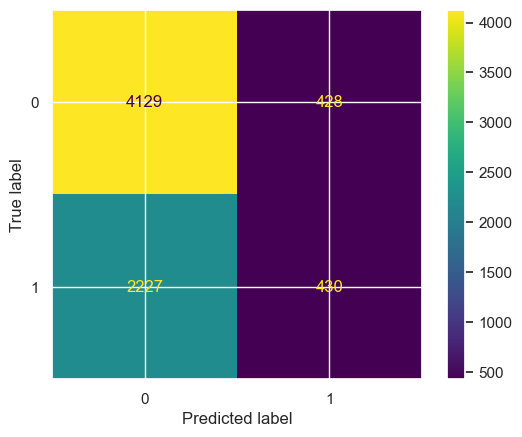

In [216]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(df_pred.two_year_recid2, df_pred.Y_hat)

In [217]:
# Ratio of false positives to false negatives
428/2227

0.19218679838347552

In [218]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
print(classification_report(df_pred.two_year_recid2, df_pred.Y_hat))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76      4557
           1       0.50      0.16      0.24      2657

    accuracy                           0.63      7214
   macro avg       0.58      0.53      0.50      7214
weighted avg       0.59      0.63      0.57      7214



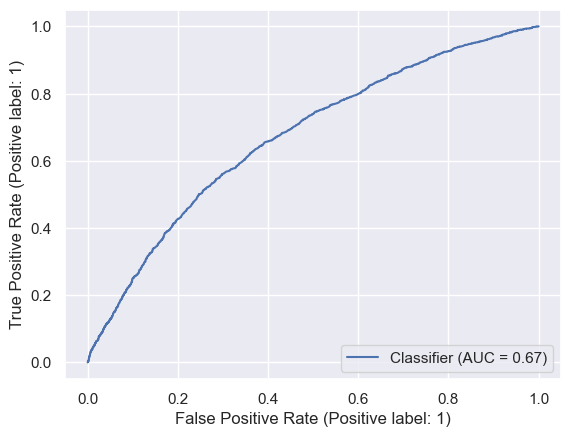

In [219]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(df_pred.two_year_recid2, df_pred.Y_score)

### Compare treatment of whites and non-whites for recidivism prediction
##### Refer to week 11 for these concepts

#### Base Rates

In [220]:
##TODO Compare base rates for recidivism outcomes of whites and non-whites

df_pred = df_pred.merge(df['race'], left_index=True, right_index=True)
df_pred_w = df_pred[df_pred['race']=='Caucasian']
df_pred_nw = df_pred[df_pred['race']!='Caucasian']

In [221]:
print("{:30s} {:.3f}".format("Non-white recidivism rate", df_pred_nw.two_year_recid2.sum() / df_pred_nw.two_year_recid2.count()))
print("{:30s} {:.3f}".format("White recidivism rate", df_pred_w.two_year_recid2.sum() / df_pred_w.two_year_recid2.count()))

Non-white recidivism rate      0.389
White recidivism rate          0.328


#### Performance

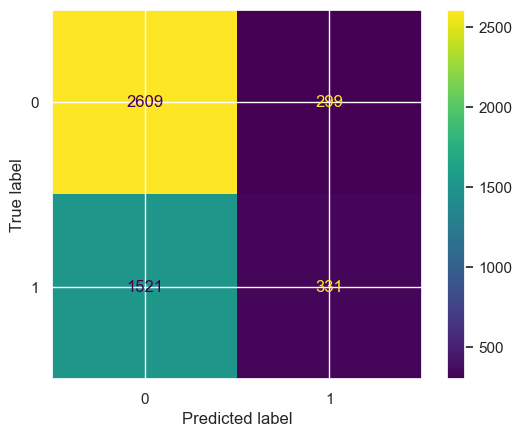

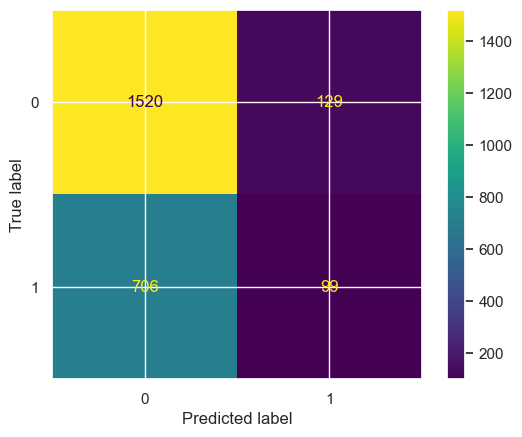

In [222]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, separately for whites and non-whites.

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(df_pred_nw.two_year_recid2, df_pred_nw.Y_hat)
ConfusionMatrixDisplay.from_predictions(df_pred_w.two_year_recid2, df_pred_w.Y_hat)

In [223]:
print('Non-white')
print(classification_report(df_pred_nw.two_year_recid2, df_pred_nw.Y_hat))
print('False positives / false negatives: %f' % (299/1521))

print('')
print('White')
print(classification_report(df_pred_w.two_year_recid2, df_pred_w.Y_hat))
print('False positives / false negatives: %f' % (129/706))

Non-white
              precision    recall  f1-score   support

           0       0.63      0.90      0.74      2908
           1       0.53      0.18      0.27      1852

    accuracy                           0.62      4760
   macro avg       0.58      0.54      0.50      4760
weighted avg       0.59      0.62      0.56      4760

False positives / false negatives: 0.196581

White
              precision    recall  f1-score   support

           0       0.68      0.92      0.78      1649
           1       0.43      0.12      0.19       805

    accuracy                           0.66      2454
   macro avg       0.56      0.52      0.49      2454
weighted avg       0.60      0.66      0.59      2454

False positives / false negatives: 0.182720


In [224]:
#Statistical parity
print('Average predicted recidivism Non-Whites:', sum(df_pred_nw.Y_hat==1)/df_pred_nw.Y_hat.count())
print('Average predicted recidivism Whites:', sum(df_pred_w.Y_hat==1)/df_pred_w.Y_hat.count())

Average predicted recidivism Non-Whites: 0.1323529411764706
Average predicted recidivism Whites: 0.09290953545232274


**What concepts of "fairness" (from class) are (approximately) satisfied by this classifier? Explain.**

Statstical parity: 
The average predicted outcome for Non-whites is about 4 percentage points higher for Non-Whites than for Whites, so statistical parity is not satisfied.

Separation:
Recall for the negative class is quite similar, but recall for the positive class is higher for Non-Whites. Recidivism is less well detected for Whites.

Precision:
Precision for the negative class is higher for Whites, for the positive class it is higher for Non-Whites.

## Assessing Judges' Decisions: Predict Judge Decision from Features

In the following you will predict judges' decisions from defendants' features using a nested training/test split as before. In a second model, include Y-hat from previous section as a predictor.

In [225]:
#TODO train a logit model to predict judge decision (D) from predictors (X). 

classifier_a = LogisticRegression()
classifier_b = LogisticRegression()

classifier_a.fit(X_a, D_a)
classifier_b.fit(X_b, D_b)

D_hat_a1 = classifier_b.predict(X_a)
D_hat_b1 = classifier_a.predict(X_b)

D_score_a1 = classifier_b.predict_proba(X_a)[:,1]
D_score_b1 = classifier_a.predict_proba(X_b)[:,1]

In [226]:
predictors.append('Y_hat')

In [227]:
X_a_Y_hat = df_pred[predictors].iloc[X_a.index]
X_b_Y_hat = df_pred[predictors].iloc[X_b.index]

In [228]:
#TODO train a logit model to predict judge decision (D) from predictors (X) and predicted recidivism risk (Yhat)
#TODO form clean test-set predictions for the decisions in the full dataset

classifier_a = LogisticRegression()
classifier_b = LogisticRegression()

classifier_a.fit(X_a_Y_hat, D_a)
classifier_b.fit(X_b_Y_hat, D_b)

D_hat_a2 = classifier_b.predict(X_a_Y_hat)
D_hat_b2 = classifier_a.predict(X_b_Y_hat)

D_score_a2 = classifier_b.predict_proba(X_a_Y_hat)[:,1]
D_score_b2 = classifier_a.predict_proba(X_b_Y_hat)[:,1]

In [229]:
D_a_df = D_a.to_frame()
D_a_df['jailed_hat'] = D_hat_a1
D_a_df['jailed_score'] = D_score_a1
D_a_df['jailed_hat2'] = D_hat_a2
D_a_df['jailed_score2'] = D_score_a2

D_b_df = D_b.to_frame()
D_b_df['jailed_hat'] = D_hat_b1
D_b_df['jailed_score'] = D_score_b1
D_b_df['jailed_hat2'] = D_hat_b2
D_b_df['jailed_score2'] = D_score_b2

D_pred = D_a_df.append(D_b_df)
df_pred = df_pred.merge(D_pred, left_index=True, right_index=True)

In [230]:
df_pred_w = df_pred[df_pred['race']=='Caucasian']
df_pred_nw = df_pred[df_pred['race']!='Caucasian']

### Compare treatment of whites and non-whites for recidivism prediction

In [231]:
##TODO Produce confusion matrices, classification reports, and ratio of false positives to false negatives, 
##TODO separately for whites and non-whites, and with/without including Y-hat as a predictor.

from sklearn.metrics import confusion_matrix

print('Prediction only with X')
print('')

print('Non-white')
print(classification_report(df_pred_nw.jailed, df_pred_nw.jailed_hat))
print(confusion_matrix(df_pred_nw.jailed, df_pred_nw.jailed_hat))
print('False positives / false negatives: %f' % (418/1395))

print('')
print('White')
print(classification_report(df_pred_w.jailed, df_pred_w.jailed_hat))
print(confusion_matrix(df_pred_w.jailed, df_pred_w.jailed_hat))
print('False positives / false negatives: %f' % (99/790))

Prediction only with X

Non-white
              precision    recall  f1-score   support

           0       0.63      0.85      0.72      2798
           1       0.58      0.29      0.38      1962

    accuracy                           0.62      4760
   macro avg       0.60      0.57      0.55      4760
weighted avg       0.61      0.62      0.58      4760

[[2380  418]
 [1395  567]]
False positives / false negatives: 0.299642

White
              precision    recall  f1-score   support

           0       0.64      0.93      0.76      1485
           1       0.64      0.18      0.29       969

    accuracy                           0.64      2454
   macro avg       0.64      0.56      0.52      2454
weighted avg       0.64      0.64      0.57      2454

[[1386   99]
 [ 790  179]]
False positives / false negatives: 0.125316


In [232]:

print('Prediction with X and Yhat')
print('')

print('Non-white')
print(classification_report(df_pred_nw.jailed, df_pred_nw.jailed_hat2))
print(confusion_matrix(df_pred_nw.jailed, df_pred_nw.jailed_hat2))
print('False positives / false negatives: %f' % (25/1941))

print('')
print('White')
print(classification_report(df_pred_w.jailed, df_pred_w.jailed_hat2))
print(confusion_matrix(df_pred_w.jailed, df_pred_w.jailed_hat2))
print('False positives / false negatives: %f' % (16/962))

Prediction with X and Yhat

Non-white
              precision    recall  f1-score   support

           0       0.59      0.99      0.74      2798
           1       0.46      0.01      0.02      1962

    accuracy                           0.59      4760
   macro avg       0.52      0.50      0.38      4760
weighted avg       0.53      0.59      0.44      4760

[[2773   25]
 [1941   21]]
False positives / false negatives: 0.012880

White
              precision    recall  f1-score   support

           0       0.60      0.99      0.75      1485
           1       0.30      0.01      0.01       969

    accuracy                           0.60      2454
   macro avg       0.45      0.50      0.38      2454
weighted avg       0.49      0.60      0.46      2454

[[1469   16]
 [ 962    7]]
False positives / false negatives: 0.016632


### Enforcing Statistical Parity

In this part you will find the the group-specific thresholds for both models of judges' decision (with/without Yhat) that obtain statistical parity.

You can use a custom classifier `threshold` for the decision with this type of code snippet: `decisions = (logit.predict_proba(X) >= threshold).astype(int)`.

#### Model without Yhat

In [233]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites

# Average predicted outcome per group
N_w = df_pred_w.jailed_hat.count()
N_nw = df_pred_nw.jailed_hat.count()
avg_y_pred_w = df_pred_w[df_pred_w['jailed_hat'] == 1].count()['jailed_hat']/N_w
avg_y_pred_nw = df_pred_nw[df_pred_nw['jailed_hat'] == 1].count()['jailed_hat']/N_nw

print("Average predicted outcome Whites:", avg_y_pred_w)
print("Average predicted outcome Non-Whites:", avg_y_pred_nw)

Average predicted outcome Whites: 0.1132844335778321
Average predicted outcome Non-Whites: 0.20693277310924368


In [234]:
difference = 15
threshold = 0.5
epsilon = 0.01

while difference > epsilon:
    threshold = threshold + 0.01
    avg_y_pred_w = sum(df_pred_w.jailed_score >= threshold)/N_w
    avg_y_pred_nw = sum(df_pred_nw.jailed_score >= threshold)/N_nw
    difference = abs(avg_y_pred_w - avg_y_pred_nw)

In [235]:
print("The largest threshold to enforce statistical parity is:", threshold)
print("Average predicted outcome Whites:", avg_y_pred_w)
print("Average predicted outcome Non-Whites:", avg_y_pred_nw)

The largest threshold to enforce statistical parity is: 0.8000000000000003
Average predicted outcome Whites: 0.004482477587612062
Average predicted outcome Non-Whites: 0.013445378151260505


In [236]:
difference = 15
threshold = 0.5
epsilon = 0.01

while difference > epsilon:
    threshold = threshold - 0.01
    avg_y_pred_w = sum(df_pred_w.jailed_score >= threshold)/N_w
    avg_y_pred_nw = sum(df_pred_nw.jailed_score >= threshold)/N_nw
    difference = abs(avg_y_pred_w - avg_y_pred_nw)

In [237]:
print("The largest threshold to enforce statistical parity is:", threshold)
print("Average predicted outcome Whites:", avg_y_pred_w)
print("Average predicted outcome Non-Whites:", avg_y_pred_nw)

The largest threshold to enforce statistical parity is: 0.21999999999999975
Average predicted outcome Whites: 0.9951100244498777
Average predicted outcome Non-Whites: 0.9964285714285714


#### Model with Yhat

In [238]:
##Find the largest and lowest thresholds to enforce statistical parity
##hint: build a recursive function to find the probability threshold that minimizes 
## the difference between the predicted outcomes for whites and non whites

# Average predicted outcome per group
N_w = df_pred_w.jailed_hat2.count()
N_nw = df_pred_nw.jailed_hat2.count()
avg_y_pred_w = df_pred_w[df_pred_w['jailed_hat2'] == 1].count()['jailed_hat2']/N_w
avg_y_pred_nw = df_pred_nw[df_pred_nw['jailed_hat2'] == 1].count()['jailed_hat2']/N_nw

print("Average predicted outcome Whites:", avg_y_pred_w)
print("Average predicted outcome Non-Whites:", avg_y_pred_nw)

difference = 15
threshold = 0.5
epsilon = 0.01

while difference > epsilon:
    threshold = threshold + 0.01
    avg_y_pred_w = sum(df_pred_w.jailed_score >= threshold)/N_w
    avg_y_pred_nw = sum(df_pred_nw.jailed_score >= threshold)/N_nw
    difference = abs(avg_y_pred_w - avg_y_pred_nw)

print("The largest threshold to enforce statistical parity is:", threshold)
print("Average predicted outcome Whites:", avg_y_pred_w)
print("Average predicted outcome Non-Whites:", avg_y_pred_nw)

difference = 15
threshold = 0.5
epsilon = 0.01

while difference > epsilon:
    threshold = threshold - 0.01
    avg_y_pred_w = sum(df_pred_w.jailed_score >= threshold)/N_w
    avg_y_pred_nw = sum(df_pred_nw.jailed_score >= threshold)/N_nw
    difference = abs(avg_y_pred_w - avg_y_pred_nw)

print("The smallest threshold to enforce statistical parity is:", threshold)
print("Average predicted outcome Whites:", avg_y_pred_w)
print("Average predicted outcome Non-Whites:", avg_y_pred_nw)

Average predicted outcome Whites: 0.009372453137734311
Average predicted outcome Non-Whites: 0.009663865546218488
The largest threshold to enforce statistical parity is: 0.8000000000000003
Average predicted outcome Whites: 0.004482477587612062
Average predicted outcome Non-Whites: 0.013445378151260505
The smallest threshold to enforce statistical parity is: 0.21999999999999975
Average predicted outcome Whites: 0.9951100244498777
Average predicted outcome Non-Whites: 0.9964285714285714


# Bonus 1: More Fairness Constraints

Find the threshold for both models (with/without Yhat) that obtains error rate balance (equality of recalls for each class.

In [239]:
##TODO

Find the threshold for both models (with/without Yhat) that obtains predictive parity (equality of precisions for each class).

In [240]:
##TODO

Find the threshold for both models (with/without Yhat) that obtains treatment equality (ratio of false positives to false negatives).

In [241]:
##TODO

# Bonus 2: Pre-Processing for Fairness

Regress all predictors in `X` on the protected attribute `A` and produce residuals `Xtilde`. Re-do the prediction task above (predicting judges' decision) and discuss how it changes the fairness metrics.

In [242]:
##TODO